In [ ]:
! pip install mediapy torch

In [16]:
# импорт зависимостей
import cv2
import mediapy
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

# настройка matplotlib
%config InlineBackend.figure_format = "retina"
plt.style.use("seaborn-v0_8-notebook")

# путь к данным
DATA_DIR = Path("../data")

#### **Детектор ключевых точек SIFT**

##### **Читаем изображения**

image1,image2

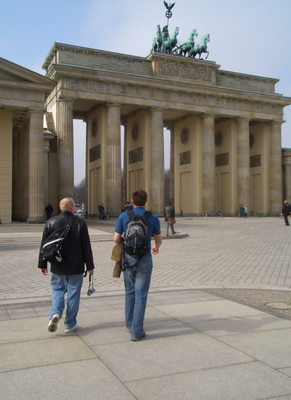
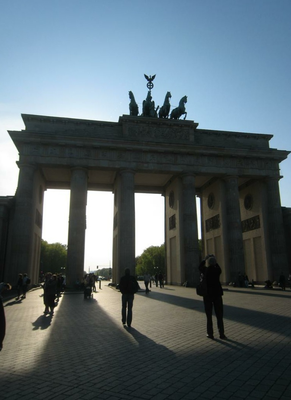

In [5]:
image1 = cv2.imread(DATA_DIR / "brandenburg_gate_1.jpg", cv2.IMREAD_COLOR_RGB)
image2 = cv2.imread(DATA_DIR / "brandenburg_gate_2.jpg", cv2.IMREAD_COLOR_RGB)

mediapy.show_images({"image1": image1, "image2": image2}, border=True, height=400)

##### **Создание SIFT детектора**

- `nfeature`: максимальное число лучших особых точек

- `nOctaveLayers`: число слоев в каждой октаве

- `contrastThreshold`: порог для фильтрации слабых особенностей по контрасту

- `edgeThreshold`: порог для фильтрации граничных точек

- `sigma`: $\sigma_1$ в первой октаве

In [6]:
sift = cv2.SIFT_create(
    nfeatures = 1000,
    edgeThreshold = 6,
    contrastThreshold = 0.04,
    nOctaveLayers = 3,
    sigma = 1.6
)

##### **Вычислим и отобразим особые точки**

output_image1,output_image2

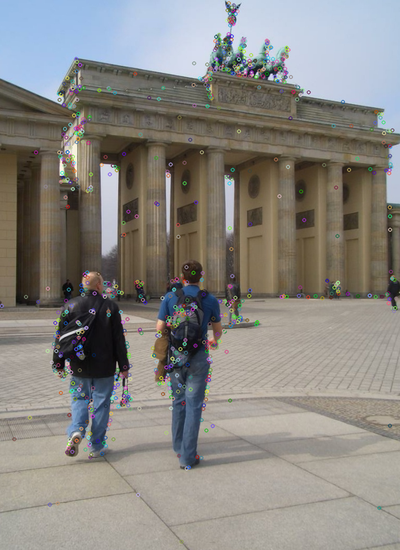
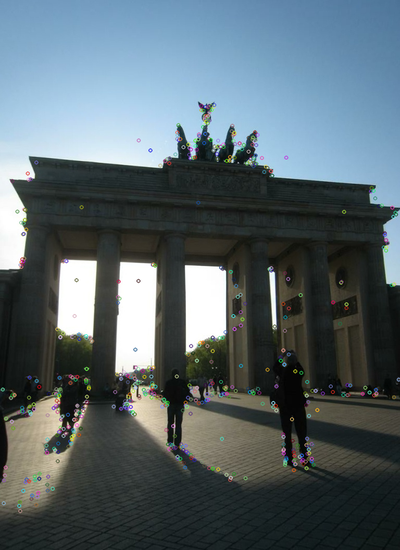

In [8]:
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

output_image1 = image1.copy()
cv2.drawKeypoints(image1, keypoints1, output_image1);

output_image2 = image2.copy()
cv2.drawKeypoints(image2, keypoints2, output_image2);

mediapy.show_images({"output_image1": output_image1, "output_image2": output_image2}, border=True, width=400)

##### **У каждой особой точки есть атрибуты**
- координаты
- ориентация
- размер
- дескриптор

In [9]:
n = 10

kp = keypoints1[n]
desc = descriptors1[n]

print(f"Coordinates of keypoint {n}: {kp.pt}")
print(f"Angle of keypoint {n}:       {kp.angle:.2f}")
print(f"Size of keypoint {n}:        {kp.size:.2f}")
print(f"Descriptor of keypoint {n}:\n{np.array_str(desc, precision=6, suppress_small=True)}")

Coordinates of keypoint 10: (499.90374755859375, 149.2751922607422)
Angle of keypoint 10:       205.53
Size of keypoint 10:        4.71
Descriptor of keypoint 10:
[  1.   0.   2.   5.   1.   6.  46.   6.   1.   1.   3.   1.   0.   4.
  44.  10.   4.   1.   1.   0.   0.   1.  44.  53.   0.   0.   0.   0.
   2.  14.  51.  24.   3.   5.  17.  14.   9.  12.   4.   1.  26.  16.
  43.  26.  15.   3.   6.   5. 131.  22.  12.   2.   4.  11.  35. 117.
  26.  10.   4.  11.  87.  92.  54.  54.   7.  21.  38.  37. 130.  58.
   7.   1.  65.  39.  61.  41.  36.   6.   1.   5. 131. 126.  27.  13.
   9.   3.   1.  22.  35.  52.  53. 131. 131.  12.   2.   7.   1.   7.
  34.  85. 131.  10.   7.   5.  75.  38.  54.  12.   3.   1.   7.  65.
  83.  59.  36.  41.  30.   3.   2.  37.   5.  13.  50. 131.  48.   0.
   1.   7.]


##### **Отобразим ориентацию и размер особых точек**

""

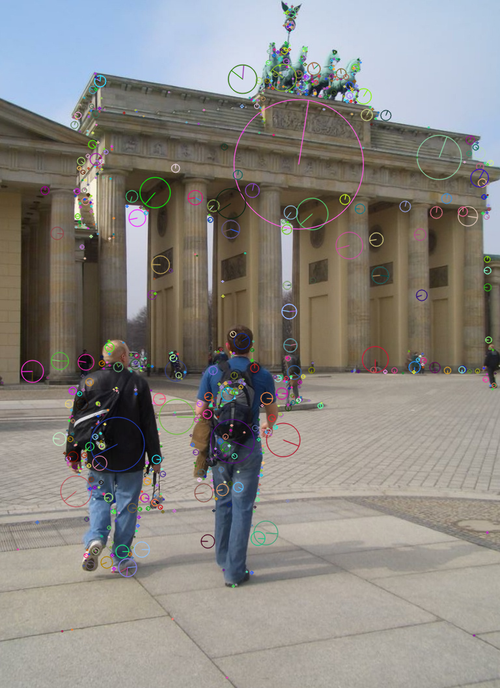

In [11]:
cv2.drawKeypoints(image1, keypoints1, output_image1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS);

mediapy.show_image(output_image1, width=500)

##### **Brute-Force Matching**

""

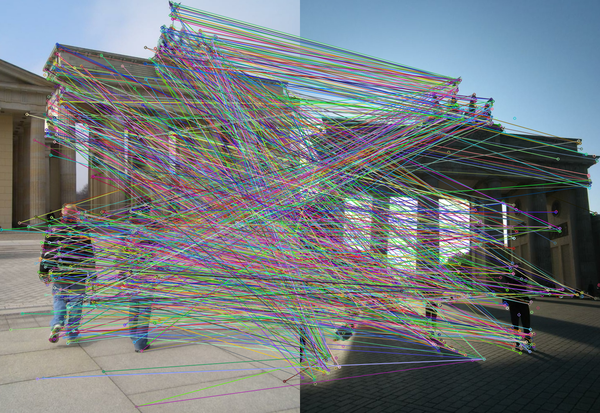

In [13]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2)

matches = bf.knnMatch(descriptors1, descriptors2, k=1)

# Draw matches.
matches_image = cv2.drawMatchesKnn(image1,
    keypoints1,
    image2,
    keypoints2,
    matches,
    outImg=None,
)

mediapy.show_image(matches_image, width=600)

##### **Brute-Force Cross Check Matching**

""

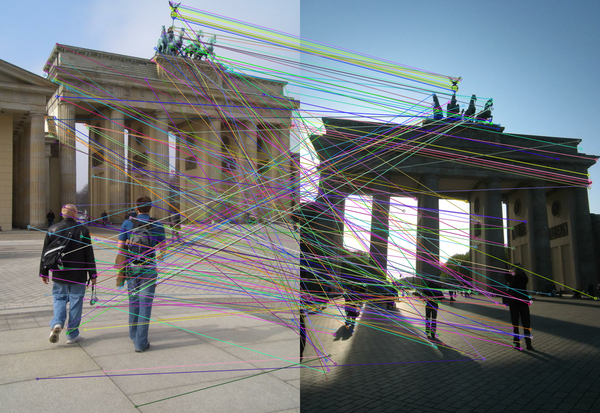

In [14]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
 
# Match descriptors.
matches = bf.match(descriptors1, descriptors2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 200 matches.
matches_image = cv2.drawMatches(
    image1, keypoints1,
    image2, keypoints2,
    matches[:200],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

mediapy.show_image(matches_image, width=600)

##### **FLANN Matching with Ratio Test**

""

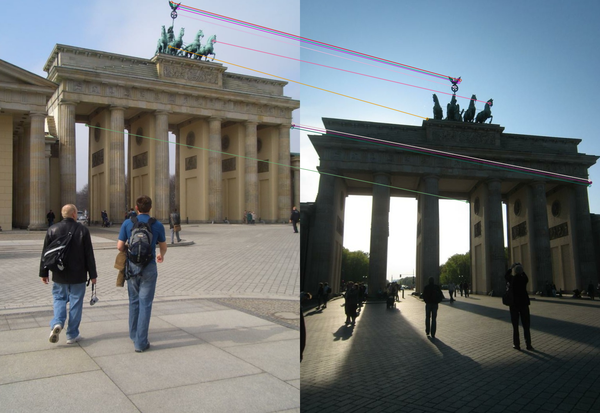

In [15]:
# FLANN matcher
flann = cv2.FlannBasedMatcher(
    {"algorithm": 1, "trees": 5}
)
 
matches = flann.knnMatch(descriptors1, descriptors2, k=2)
 
# Apply ratio test
good = []

for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append([m])

matches_image = cv2.drawMatchesKnn(
    image1, keypoints1,
    image2, keypoints2,
    good,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

mediapy.show_image(matches_image, width=600)

#### **Детектор ключевых точек SuperPoint**

In [19]:
class SuperPointNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)

        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    @torch.inference_mode()
    def forward(self, image):
        x = torch.from_numpy(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)) / 255.0
        x = x[None, None]

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)

        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
        coarse_desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.

        semi = semi.cpu().numpy().squeeze()
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0) + .00001) # Should sum to 1.
        # Remove dustbin.
        nodust = dense[:-1, :, :]

        h, w = nodust.shape[1:3]
        H, W = 8 * h, 8 * w

        nodust = nodust.transpose(1, 2, 0)
        heatmap = np.reshape(nodust, [h, w, 8, 8])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [h * 8, w * 8])
        xs, ys = np.where(heatmap >= 0.015) # Confidence threshold.

        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heatmap[xs, ys]

        pts, _ = self.nms_fast(pts, H, W, dist_thresh=4) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:, inds[::-1]] # Sort by confidence.

        # Interpolate into descriptor map using 2D point locations.
        samp_pts = torch.from_numpy(pts[:2, :].copy())
        samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
        samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
        samp_pts = samp_pts.transpose(0, 1).contiguous()
        samp_pts = samp_pts.view(1, 1, -1, 2)
        samp_pts = samp_pts.float()
        desc = nn.functional.grid_sample(coarse_desc, samp_pts, align_corners=True)
        D = coarse_desc.shape[1]
        desc = desc.cpu().numpy().reshape(D, -1)
        desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

        keypoints = pts[:2].T.astype(int)
        descriptors = desc.T.astype(np.float32)

        return keypoints, descriptors

    def nms_fast(self, in_corners, H, W, dist_thresh):
        grid = np.zeros((H, W)).astype(int) 
        inds = np.zeros((H, W)).astype(int) 
        
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2, :])
        corners = in_corners[:, inds1]
        rcorners = corners[:2, :].round().astype(int)  # Rounded corners.
        
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3, 0)).astype(int), np.zeros(0).astype(int)
        
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3, 1)
            return out, np.zeros((1)).astype(int)
        
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1, i], rcorners[0, i]] = 1
            inds[rcorners[1, i], rcorners[0, i]] = i
        
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad, pad), (pad, pad)), mode="constant")
        
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        
        for i, rc in enumerate(rcorners.T):
            # Account for top and left padding.
            pt = (rc[0] + pad, rc[1] + pad)
        
            if grid[pt[1], pt[0]] == 1:  # If not yet suppressed.
                grid[pt[1] - pad : pt[1] + pad + 1, pt[0] - pad : pt[0] + pad + 1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid == -1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        
        return out, out_inds

##### **Создание и загрузка весов обученной модели SuperPointNet**

In [18]:
net = SuperPointNet()
net.load_state_dict(torch.load(DATA_DIR / "superpoint.pth"))


<All keys matched successfully>

##### **Network inference**

In [26]:
pts1, des1 = net(image1)
pts2, des2 = net(image2)

print(f"pts1 shape: {pts1.shape}")
print(f"pts2 shape: {pts2.shape}\n")

print(f"des1 shape: {des1.shape}")
print(f"des2 shape: {des2.shape}")

pts1 shape: (968, 2)
pts2 shape: (717, 2)

des1 shape: (968, 256)
des2 shape: (717, 256)


##### **Отобразим ключевые точки**

""

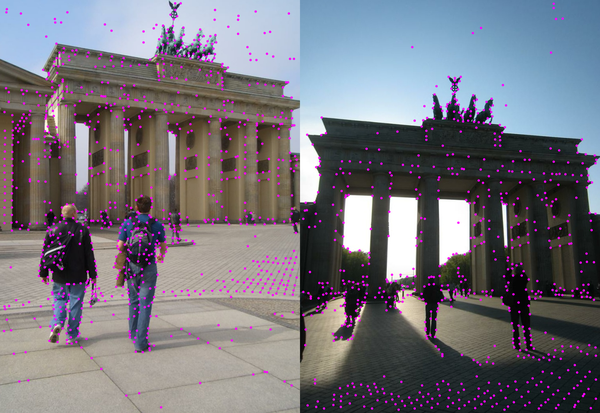

In [28]:
otput_image = np.concatenate((image1, image2), axis=1)

H, W = image2.shape[:2]

for x, y in pts1:
    cv2.circle(otput_image, (x, y), 3, (255, 0, 255), -1)

for x, y in pts2:
    cv2.circle(otput_image, (x + W, y), 3, (255, 0, 255), -1)

mediapy.show_image(otput_image, width=600)

##### **Вычисление матрицы расстояний между дескрипторами**

$$
    ||\mathbf{d_1}-\mathbf{d_2}||^2=||\mathbf{d_1}||^2+||\mathbf{d_2}||^2-2(\mathbf{d_1},\mathbf{d_2})=
    2\left[1-(\mathbf{d_1},\mathbf{d_2})\right]
$$

$$
    (\mathbf{d_1},\mathbf{d_2})=||\mathbf{d_1}||\cdot||\mathbf{d_2}||\cos\alpha =\cos\alpha 
$$

In [31]:
dots = np.dot(des1, des2.T)
dist = np.sqrt(2 - 2 * np.clip(dots, -1, 1))

print(f"dist shape: {dist.shape}")
print(f"dist min: {dist.min()}")
print(f"dist max: {dist.max()}")

dist shape: (968, 717)
dist min: 0.35905376076698303
dist max: 1.7653863430023193
